<a href="https://colab.research.google.com/github/chengharv-pen/FashionMNIST-Classifier/blob/main/code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Google Colab T4 hosted runtime was used to run this code. Total runtime should not exceed 10min.

### Import necessary libraries

In [1]:
import os
import math
import itertools
import random

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import root_mean_squared_error, mean_absolute_error

import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import Dataset, TensorDataset, random_split
import torch.optim as optim

from torchvision import datasets
from torchvision.transforms import ToTensor

from tqdm.notebook import tqdm

# 1. Building the Neural Network using PyTorch

Creating a class of type nn.module... The input will be 28x28 images from the FashionMNIST dataset (784). The module should allow the construction of a network as follows:

`net = my_nn_model()`

## Load the FashionMNIST dataset

In [2]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

100%|██████████| 26.4M/26.4M [00:02<00:00, 11.8MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 210kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.97MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 14.6MB/s]


In [3]:
print(training_data.data.shape)
print(test_data.data.shape)

torch.Size([60000, 28, 28])
torch.Size([10000, 28, 28])


## Define the my_nn_model class

In [4]:
class my_nn_model(nn.Module):
    def __init__(self, input_size=784, hidden_size=16, output_size=10, depth=8):
        """
        A constructor that defines the network's architecture.

        Args:
            input_size (int, optional): The amount of units from the input layer. Should be equivalent to the number of features. Defaults to 784.
            hidden_size (int, optional): The amount of units in the hidden layer. Defaults to 16.
            output_size (int, optional): The amount of units in the output layer. Defaults to 10.
            depth (int, optional): _description_. Defaults to 8.
        """
        super(my_nn_model, self).__init__()

        layers = [nn.Linear(input_size, hidden_size)] # input -> hidden 1

        # hidden 1 -> hidden 2 -> 3 -> ... -> depth
        for _ in range(depth - 1): # depth 8 - 1, because we already took care of Hidden 1
            layers.append(nn.Linear(hidden_size, hidden_size))


        self.output = nn.Linear(hidden_size, output_size) # hidden 8 -> output
        self.hidden_layers = nn.ModuleList(layers) # register all hidden layers

    def forward(self, x, retain_for_grad=False):
        """
        A method that will do a forward pass through the network using input x.

        Args:
            x (torch.Tensor): Input
            retain_for_grad (bool, optional): Whether to keep intermediate activations
                                              for gradient inspection. Defaults to False.

        Returns:
            out (torch.Tensor): The network’s output after the final layer.
            activations (list[torch.Tensor] or None): List of intermediate activations
                                                      if retain_for_grad=True, else None.
        """
        x = x.view(x.size(0), -1)  # flatten input
        activations = []           # modification for (c), this will save gradient values

        # forward through hidden layers with ReLU
        for layer in self.hidden_layers:
            x = F.relu(layer(x))

            # modification for (c)
            # keeps gradients of intermediate activations after backward()
            if retain_for_grad:
                x.retain_grad()
            activations.append(x)

        out = self.output(x) # output layer

        # return both if we're analyzing gradients
        if retain_for_grad:
            return out, activations
        else:
            return out

    def initialize_weights(self, d_type="xavier", d_value=None):
        """
        This method will use Xavier initialization by default, unless specified otherwise.
        It initializes model weights and biases:
          - Weights: Uniform in [-d, d]
          - Biases: 0

        Args:
            d_type (str, optional): The initialization type. Defaults to "xavier".
            d_value (_type_, optional): The initialization value, if initialization type is fixed. Defaults to None.

        Raises:
            ValueError: If we do not get xavier or fixed as d_type, this error is raised.
        """
        for layer in list(self.hidden_layers) + [self.output]:
            if isinstance(layer, nn.Linear):
                n_i, n_o = layer.in_features, layer.out_features

                # Determine d based on d_type
                if d_type == "xavier":
                    d = math.sqrt(6 / (n_i + n_o))
                elif d_type == "fixed" and d_value is not None:
                    d = d_value
                else:
                    raise ValueError("Specify either d_type='xavier' or d_type='fixed' with d_value.")

                nn.init.uniform_(layer.weight, -d, d) # uniform weight initialization
                nn.init.zeros_(layer.bias)            # zero bias

## Verifying that it allows the construction of the network as required

In [5]:
net = my_nn_model()

Testing model initialization functions...

In [6]:
# see initialize_weights() in the my_nn_model class defined above
# Example usage defined below

# d = 0.01
net.initialize_weights(d_type="fixed", d_value=0.01)

# d = 0.1
net.initialize_weights(d_type="fixed", d_value=0.1)

# d = 1.0
net.initialize_weights(d_type="fixed", d_value=1.0)

# Xavier initialization (d = sqrt(6 / (n_i + n_o)))
net.initialize_weights(d_type="xavier")

# 2. Computing and visualizing gradient norms

Using a cross-entropy loss at the end of the network: forward and backward a minibatch of 128 MNIST digits through the network with depth 8. Compute and visualize the gradient norm at each layer. Specifically this refers to the $||\frac{∂L}{∂a}||$, where a are the post-activation outputs. The plots should have a layer on the x-axis and gradient norm on the y-axis. Note that to get the gradient norms at each layer, retain_grad can be used on the layer outputs in the forward pass to keep the gradient buffer from clearing at each layer on the backward. Perform this for each of the four (4) initializations to obtain four (4) curves.

### Load the MNIST digits dataset and use DataLoader for mini-batches

In [7]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [8]:
trainset = datasets.MNIST(
    root='data',
    train=True,
    download=True,
    transform=ToTensor()
)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=128)

# one batch, 128 MNIST digits
images, labels = next(iter(trainloader))

100%|██████████| 9.91M/9.91M [00:00<00:00, 17.3MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 538kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.50MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 11.0MB/s]


### Verify that shapes are correct

In [9]:
print(images.shape)
print(labels.shape)

torch.Size([128, 1, 28, 28])
torch.Size([128])


### Compute gradient norms for the mini-batch

This is done for every required configuation of <code>initialize_weights()</code>

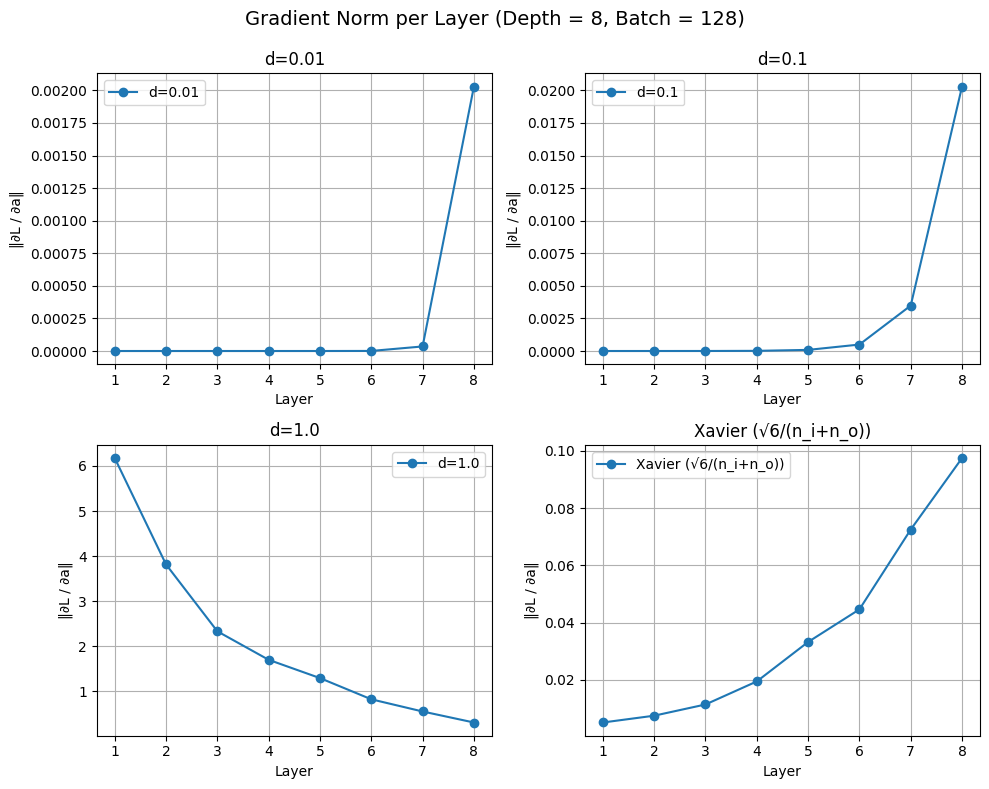

In [10]:
# configurations for every initialize_weights() call
init_configs = [
    ("fixed", 0.01, "d=0.01"),
    ("fixed", 0.1, "d=0.1"),
    ("fixed", 1.0, "d=1.0"),
    ("xavier", None, "Xavier (√6/(n_i+n_o))")
]

fig, axes = plt.subplots(2, 2, figsize=(10, 8))
fig.suptitle("Gradient Norm per Layer (Depth = 8, Batch = 128)", fontsize=14)

# flatten axes array to make iteration easier
axes = axes.flatten()

for ax, (d_type, d_val, label) in zip(axes, init_configs):
    # before starting a trial, set global seed
    set_seed(433)

    model = my_nn_model()
    model.initialize_weights(d_type=d_type, d_value=d_val)

    # forward pass, calculate cross entropy loss after it
    logits, activations = model(images, retain_for_grad=True)
    loss_fn = nn.CrossEntropyLoss()
    loss = loss_fn(logits, labels)

    # backward pass
    model.zero_grad()
    loss.backward()

    # compute gradient norms for activations
    grad_norms = []
    for a in activations:
        grad_norms.append(a.grad.norm().item())

    ax.plot(range(1, 9), grad_norms, marker='o', label=label)
    ax.set_title(label)
    ax.set_xlabel("Layer")
    ax.set_ylabel("‖∂L / ∂a‖")
    ax.grid(True)
    ax.legend()

    # different way to visualize
    # ax.set_yscale('log')

# rect=[left, bottom, right, top]
plt.tight_layout(rect=[0, 0, 1, 0.99])  # leave space for main title
plt.show()

# 3. Comparing initialization settings accuracies

For each initialization setting, we will train the model for 5 epochs on FashionMNIST, using the cross-entropy loss.

SGD with a learning rate of 0.01 and minibatch sizes of 128.

Record the training accuracy and testing accuracy after each epoch and plot them versus epochs.


### Use DataLoader for mini-batches again

In [11]:
# We previously loaded the FashionMNIST train and test data in Cell 2...
# They were tied to variables named training_data and test_data respectively.
fashion_trainloader = torch.utils.data.DataLoader(training_data, batch_size=128)
fashion_testloader = torch.utils.data.DataLoader(test_data, batch_size=128)

### Define helper functions for training

In [12]:
def train_one_epoch(model, optimizer, criterion, dataloader, device):
    """
    A function that trains the model for one epoch

    Args:
        model (my_nn_model): A custom model class that is a subclass of torch.nn.Module
        optimizer (torch.optim.Optimizer): The optimizer used for the gradient changes
        criterion (torch.nn.CrossEntropyLoss): The loss function to optimize
        dataloader (torch.utils.data.DataLoader): A DataLoader that will split the dataset into iterable batches
        device (str): Defines if CPU or CUDA will be used for training loop

    Returns:
        running_loss / len(dataloader) (): Average batch loss
        acc (float): Train accuracy value
    """
    model.train()
    correct, total, running_loss = 0, 0, 0.0

    # iterate through batches
    for images, labels in tqdm(dataloader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        # predict, this will do a forward pass
        outputs = model(images)

        # calculate losses, and do backward pass
        loss = criterion(outputs, labels)
        loss.backward()

        optimizer.step()

        # calculate statistics
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    acc = 100 * correct / total
    return running_loss / len(dataloader), acc


def evaluate(model, criterion, dataloader, device):
    """
    A function that evaluates a trained model

    Args:
        model (my_nn_model): A custom model class that is a subclass of torch.nn.Module
        criterion (torch.nn.CrossEntropyLoss): The loss function to optimize
        dataloader (torch.utils.data.DataLoader): A DataLoader that will split the dataset into iterable batches
        device (str): Defines if CPU or CUDA will be used for training loop

    Returns:
        running_loss / len(dataloader) (): Average batch loss
        acc (float): Test accuracy value
    """
    model.eval()
    correct, total, running_loss = 0, 0, 0.0

    with torch.no_grad():
        # iterate through batches
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            # predict, this will do a forward pass
            outputs = model(images)

            # calculate losses
            loss = criterion(outputs, labels)

            # calculate statistics
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    acc = 100 * correct / total
    return running_loss / len(dataloader), acc

### Train the model for every initialization

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

init_configs = [
    ("fixed", 0.01, "d = 0.01"),
    ("fixed", 0.1,  "d = 0.1"),
    ("fixed", 1.0,  "d = 1.0"),
    ("xavier", None, "Xavier (√6 / (n_i + n_o))")
]

print(device)

cuda


In [14]:
num_epochs = 5
criterion = nn.CrossEntropyLoss()
results = {}

for d_type, d_val, label in init_configs:
    # before starting a trial, set global seed
    set_seed(433)

    print(f"\n=== Training with {label} ===")

    model = my_nn_model().to(device)
    model.initialize_weights(d_type=d_type, d_value=d_val)
    optimizer = optim.SGD(model.parameters(), lr=0.01) # this line is really important, keep it in the loop...

    train_accs, test_accs = [], []

    for epoch in range(num_epochs):
        train_loss, train_acc = train_one_epoch(model, optimizer, criterion, fashion_trainloader, device)
        test_loss, test_acc = evaluate(model, criterion, fashion_testloader, device)

        train_accs.append(train_acc)
        test_accs.append(test_acc)

        print(f"Epoch {epoch+1}/{num_epochs}: Train Acc = {train_acc:.2f}% | Test Acc = {test_acc:.2f}%")

    results[label] = (train_accs, test_accs)


=== Training with d = 0.01 ===


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 1/5: Train Acc = 9.82% | Test Acc = 10.00%


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 2/5: Train Acc = 9.88% | Test Acc = 10.00%


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 3/5: Train Acc = 9.79% | Test Acc = 10.00%


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 4/5: Train Acc = 9.69% | Test Acc = 10.00%


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 5/5: Train Acc = 9.71% | Test Acc = 10.00%

=== Training with d = 0.1 ===


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 1/5: Train Acc = 9.81% | Test Acc = 10.00%


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 2/5: Train Acc = 9.84% | Test Acc = 10.00%


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 3/5: Train Acc = 9.75% | Test Acc = 10.00%


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 4/5: Train Acc = 9.71% | Test Acc = 10.00%


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 5/5: Train Acc = 9.72% | Test Acc = 10.00%

=== Training with d = 1.0 ===


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 1/5: Train Acc = 21.14% | Test Acc = 27.33%


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 2/5: Train Acc = 31.22% | Test Acc = 32.90%


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 3/5: Train Acc = 36.12% | Test Acc = 38.18%


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 4/5: Train Acc = 40.21% | Test Acc = 42.21%


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 5/5: Train Acc = 45.59% | Test Acc = 49.05%

=== Training with Xavier (√6 / (n_i + n_o)) ===


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 1/5: Train Acc = 17.68% | Test Acc = 22.50%


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 2/5: Train Acc = 39.02% | Test Acc = 54.50%


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 3/5: Train Acc = 57.97% | Test Acc = 64.81%


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 4/5: Train Acc = 65.61% | Test Acc = 70.36%


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 5/5: Train Acc = 70.29% | Test Acc = 73.64%


### Plotting training/testing accuracies vs epochs

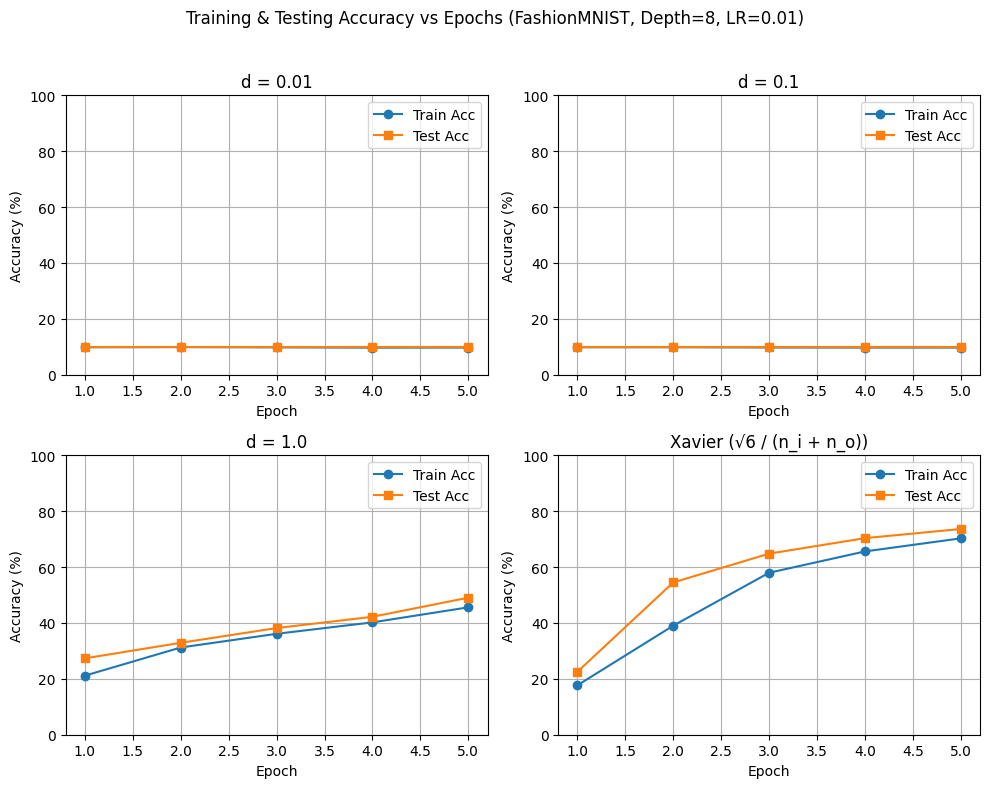

In [15]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.flatten()

for ax, (label, (train_accs, test_accs)) in zip(axes, results.items()):
    epochs = range(1, num_epochs + 1)
    ax.plot(epochs, train_accs, marker='o', label='Train Acc')
    ax.plot(epochs, test_accs, marker='s', label='Test Acc')
    ax.set_title(label)
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Accuracy (%)")
    ax.set_ylim(0, 100)
    ax.grid(True)
    ax.legend()

plt.suptitle("Training & Testing Accuracy vs Epochs (FashionMNIST, Depth=8, LR=0.01)")
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

Increasing depth generally makes the network more expressive but also more prone to issues like vanishing or exploding activations and gradients. As layers stack, small deviations in the activation scale can compound, which leads to very small or very large outputs and gradients. This would slow or prevent convergence. A good initializer (Xavier) maintains a stable variance of activations and gradients across layers, which enables smoother training and faster convergence. Poor initialization can cause activations to saturate or gradients to vanish/explode, resulting in unstable or stalled learning.

# 4. Comparing optimizers (SGD, RMSProp, Adam)

Only for the Xavier initialization, training the model for 5 epochs on FashionMNIST, using the cross-entropy loss.

Using three different optimizers and minibatch sizes of 128: SGD, RMSProp, and Adam, all with a learning rate of 0.01.

Record the training accuracy and testing accuracy after each epoch and plot them versus epochs.


### Train the model for every optimizer

In [18]:
optimizers_config = {
    "SGD": lambda params: optim.SGD(params, lr=0.01),
    "RMSProp": lambda params: optim.RMSprop(params, lr=0.01),
    "Adam": lambda params: optim.Adam(params, lr=0.01)
}

num_epochs = 5
criterion = nn.CrossEntropyLoss()
results = {}

for opt_name, opt_func in optimizers_config.items():
    # before starting a trial, set global seed
    set_seed(433)

    print(f"\n=== Training with {opt_name} ===")
    model = my_nn_model().to(device)
    model.initialize_weights()
    optimizer = opt_func(model.parameters())

    train_accs, test_accs = [], []

    for epoch in range(num_epochs):
        train_loss, train_acc = train_one_epoch(model, optimizer, criterion, fashion_trainloader, device)
        test_loss, test_acc = evaluate(model, criterion, fashion_testloader, device)
        train_accs.append(train_acc)
        test_accs.append(test_acc)

        print(f"Epoch {epoch+1}/{num_epochs}: Train Acc = {train_acc:.2f}% | Test Acc = {test_acc:.2f}%")

    results[opt_name] = (train_accs, test_accs)


=== Training with SGD ===


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 1/5: Train Acc = 17.68% | Test Acc = 22.50%


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 2/5: Train Acc = 39.02% | Test Acc = 54.50%


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 3/5: Train Acc = 57.97% | Test Acc = 64.81%


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 4/5: Train Acc = 65.61% | Test Acc = 70.36%


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 5/5: Train Acc = 70.29% | Test Acc = 73.64%

=== Training with RMSProp ===


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 1/5: Train Acc = 50.34% | Test Acc = 64.67%


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 2/5: Train Acc = 68.36% | Test Acc = 73.96%


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 3/5: Train Acc = 76.01% | Test Acc = 69.19%


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 4/5: Train Acc = 78.33% | Test Acc = 78.67%


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 5/5: Train Acc = 79.55% | Test Acc = 78.62%

=== Training with Adam ===


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 1/5: Train Acc = 69.45% | Test Acc = 79.45%


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 2/5: Train Acc = 80.76% | Test Acc = 81.29%


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 3/5: Train Acc = 82.81% | Test Acc = 82.62%


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 4/5: Train Acc = 83.12% | Test Acc = 82.31%


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 5/5: Train Acc = 83.94% | Test Acc = 82.90%


### Plot training/testing accuracies vs epochs

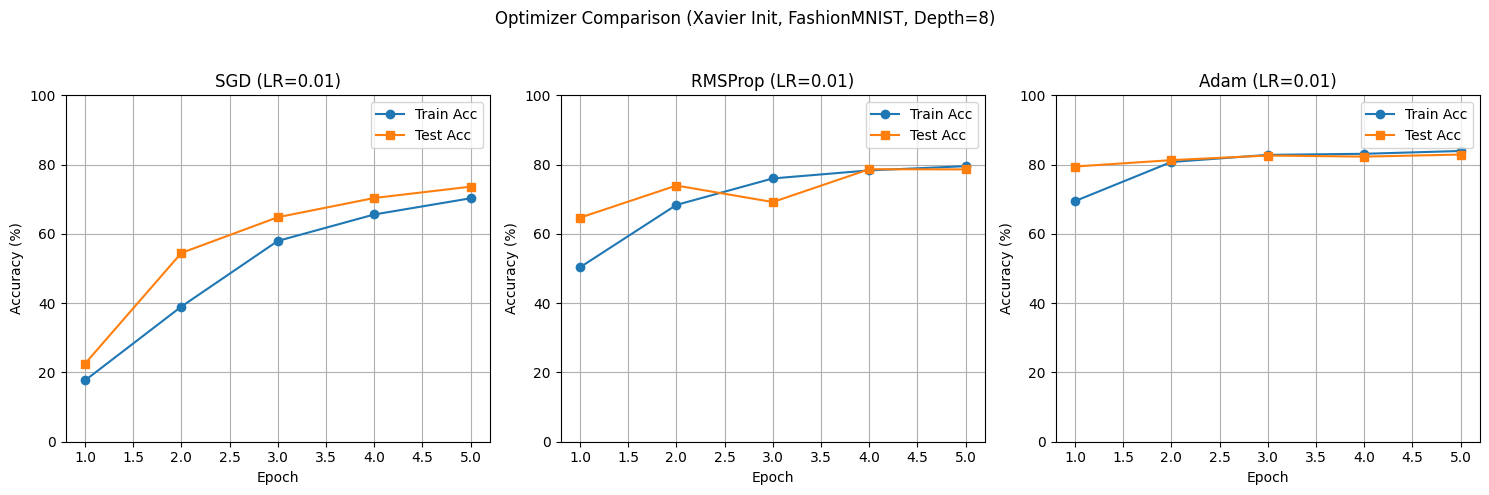

In [17]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for ax, (opt_name, (train_accs, test_accs)) in zip(axes, results.items()):
    epochs = range(1, num_epochs + 1)
    ax.plot(epochs, train_accs, marker='o', label='Train Acc')
    ax.plot(epochs, test_accs, marker='s', label='Test Acc')
    ax.set_title(f"{opt_name} (LR=0.01)")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Accuracy (%)")
    ax.set_ylim(0, 100)
    ax.legend()
    ax.grid(True)

plt.suptitle("Optimizer Comparison (Xavier Init, FashionMNIST, Depth=8)")
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

The optimizer used can affect the performance. If we compare the worst one (SGD) to the best one (Adam), we can see that the train/test accuracies on Epoch 1 differ wildly. SGD displays around 20% for both train/test, while Adam displays 70-80% values. The RMSProp optimizer stands between the worst and the best optimizers, ranging from high 40% to high 60% after the first epoch.

There is also a noticeable variation of accuracies at Epoch 5. SGD sits at around 75%, RMSProp approaching 80%, and Adam pushing a bit above 80%.